`bash` scripts:

(Active R Kernel)

https://scottzijiezhang.github.io/RADARmanual/workflow.html

In [15]:
library("RADAR")

run_radar <- function(enz, gtf,species, cutoff = 0.1, Beta_cutoff = 0.5,threads = 18){
    outputDir = paste("radar", species,enz, sep='/')
    radar <- countReads(
        samplenames = unlist(lapply (c('s23','s24'), paste, paste(species,c('NT',enz), sep='.'),sep='.')),
        gtf = gtf,
        bamFolder = "bam",
        modification = 'm6A',
        strandToKeep = "opposite",
        outputDir = outputDir,
        threads = threads,
        saveOutput = TRUE
    )
    saveRDS(radar, file = paste(outputDir,"raw.radar.rds",sep='/')) # ,compress = TRUE)
    radar <- normalizeLibrary(radar, boxPlot = FALSE)
    radar <- adjustExprLevel(radar)
    
    variable(radar) <- data.frame( Group =data.frame( Group = rep(c("Ctl","Treated"),2)) )
    radar <- filterBins(radar,minCountsCutOff = 15)
    radar <- diffIP_parallel(radar, thread = threads)
    top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
    radar <- reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, threads=threads)
    result <- results(radar)
    
    write.csv(results, paste(outputDir,'radar.bed',sep='/'), quote = FALSE, row.names = FALSE)
    saveRDS(radar, file = paste(outputDir,"radar.rds",sep='/')) # ,compress = TRUE)
}


# run radar on human bam files 

In [11]:
gtf = "/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf"

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 24.1178261041641 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”

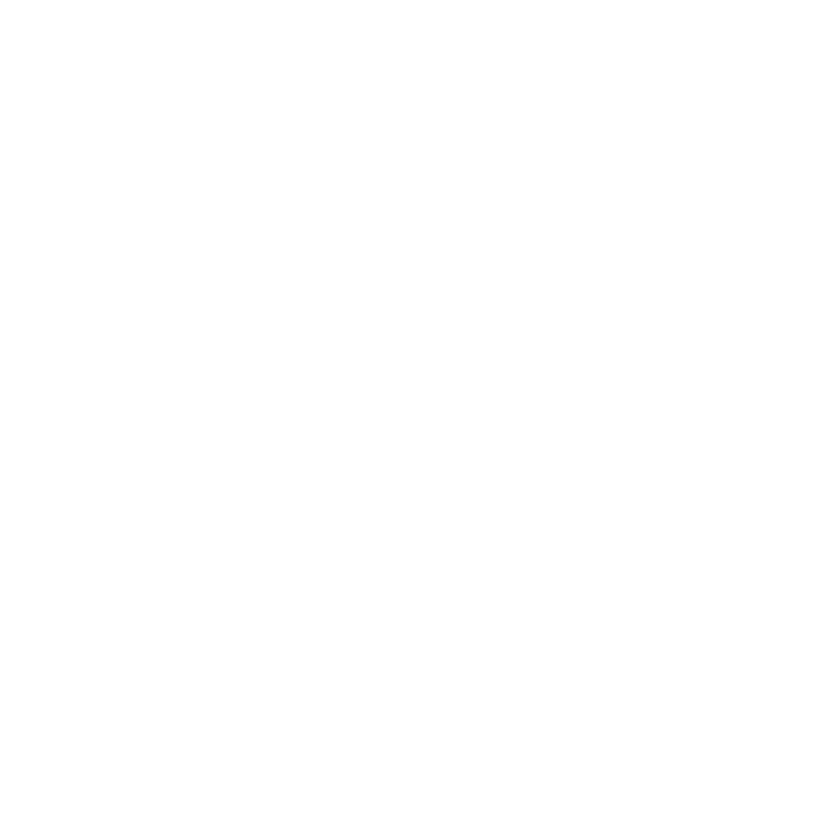

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
    Ctl Treated     Ctl Treated 
      0       1       0       1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.74136548837026 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 1.29077123006185 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 5750 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


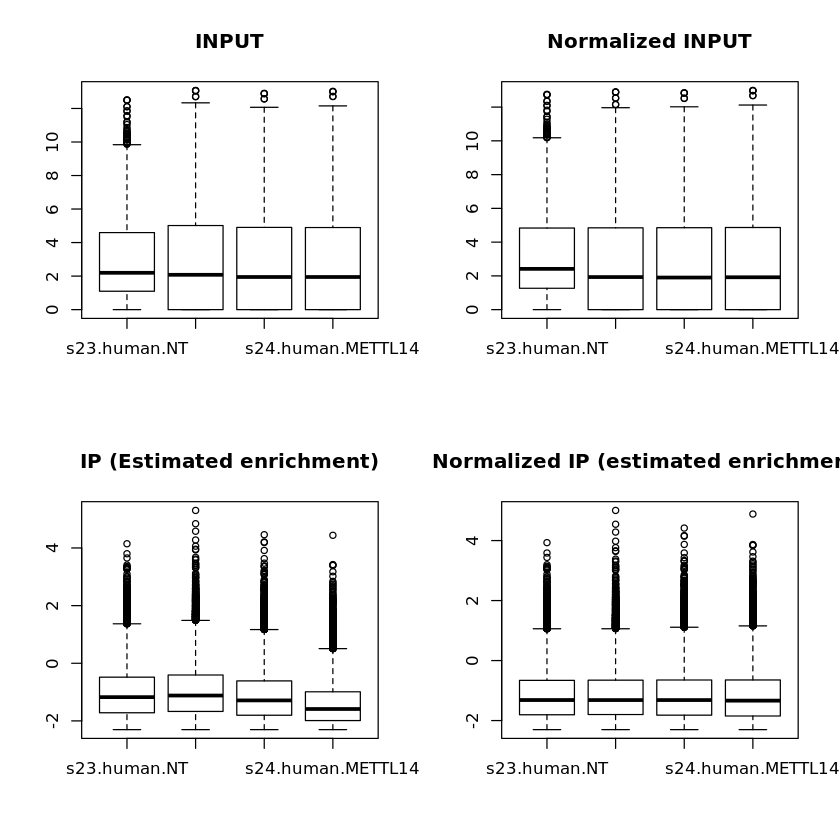

In [12]:
enz = 'METTL14'
run_radar(enz,gtf,'human')

In [14]:
enz = 'METTL3'
run_radar(enz,gtf,'human')

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


[1] "Stage: index bam file bam/s23.human.Virma.input.bam"
[1] "Stage: index bam file bam/s23.human.Virma.m6A.bam"
[1] "Stage: index bam file bam/s24.human.Virma.input.bam"
[1] "Stage: index bam file bam/s24.human.Virma.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 26.6394029458364 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 4 is not drawn”

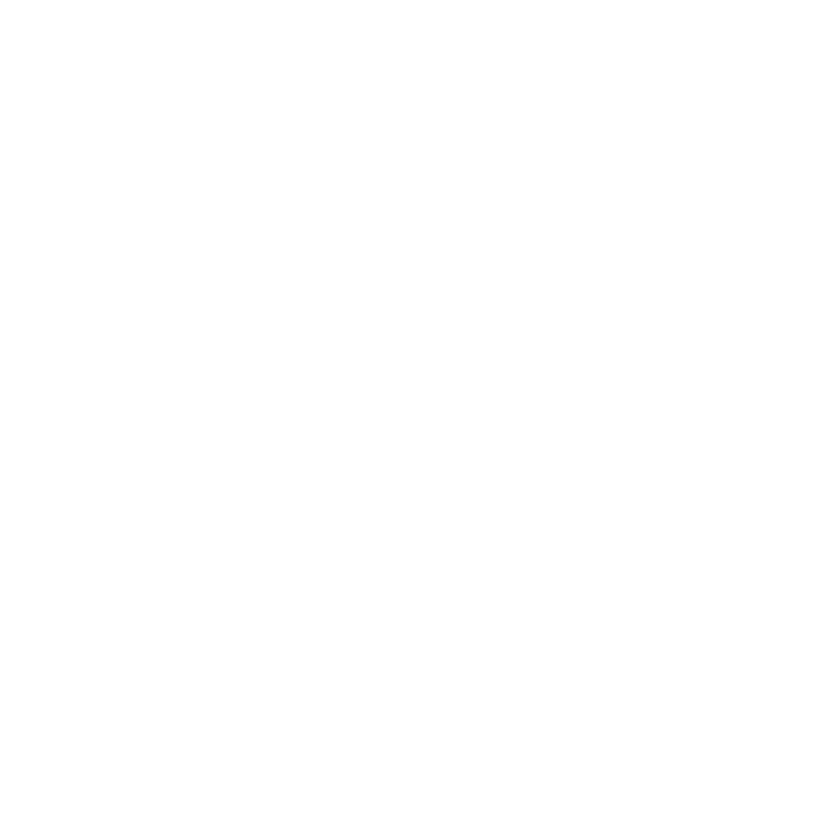

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.795921897888184 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 0.981886716683706 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 5488 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


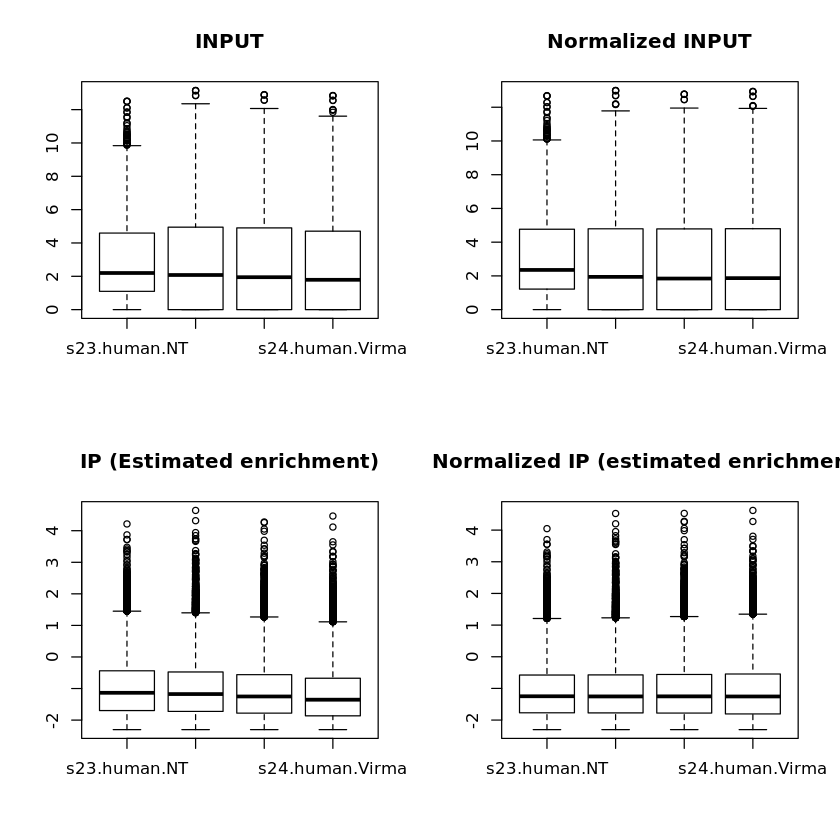

In [60]:
enz = 'Virma'
run_radar(enz,gtf,'human')

[1] "Stage: index bam file bam/s23.human.WTAP.input.bam"
[1] "Stage: index bam file bam/s23.human.WTAP.m6A.bam"
[1] "Stage: index bam file bam/s24.human.WTAP.input.bam"
[1] "Stage: index bam file bam/s24.human.WTAP.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 29.0011871933937 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 1 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 4 is not drawn”

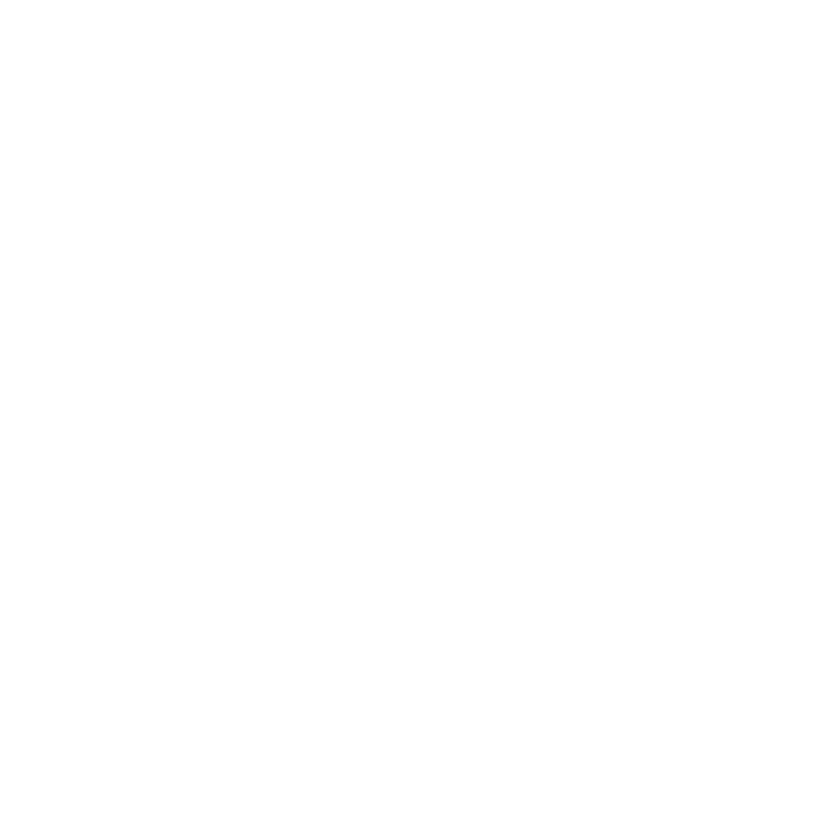

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.771063359578451 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 1.17677079439163 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 6961 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


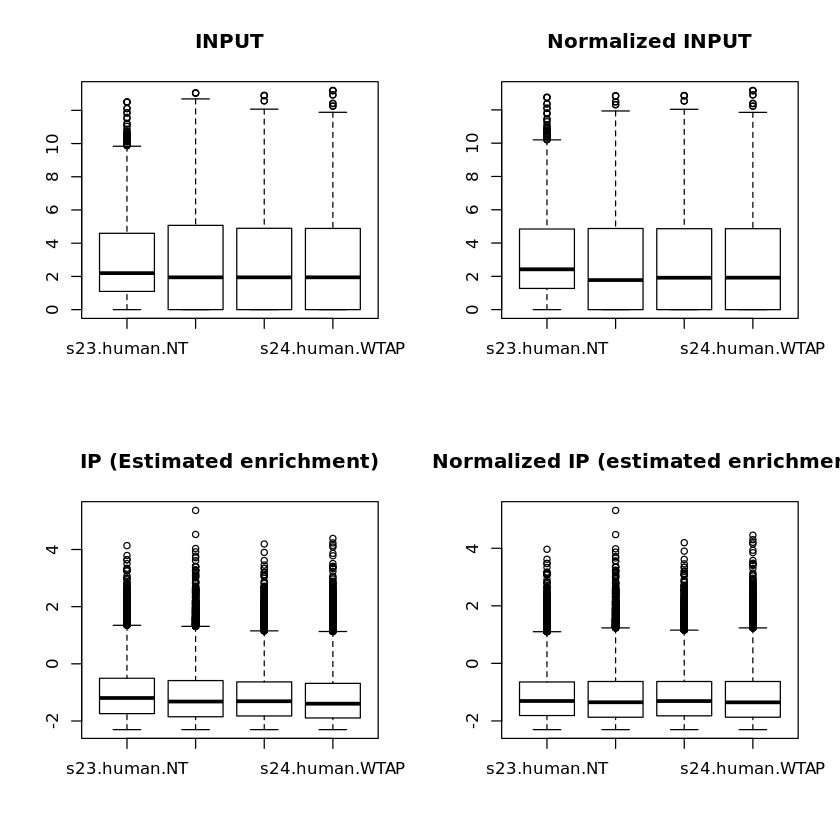

In [61]:
enz = 'WTAP'
run_radar(enz,gtf,'human')

# Plot heatmaps

In [54]:
library("RADAR")
library(repr)
options(repr.plot.width=12, repr.plot.height=15)

### METTL14

In [56]:
radar = readRDS('radar/human/METTL14/radar.rds')

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


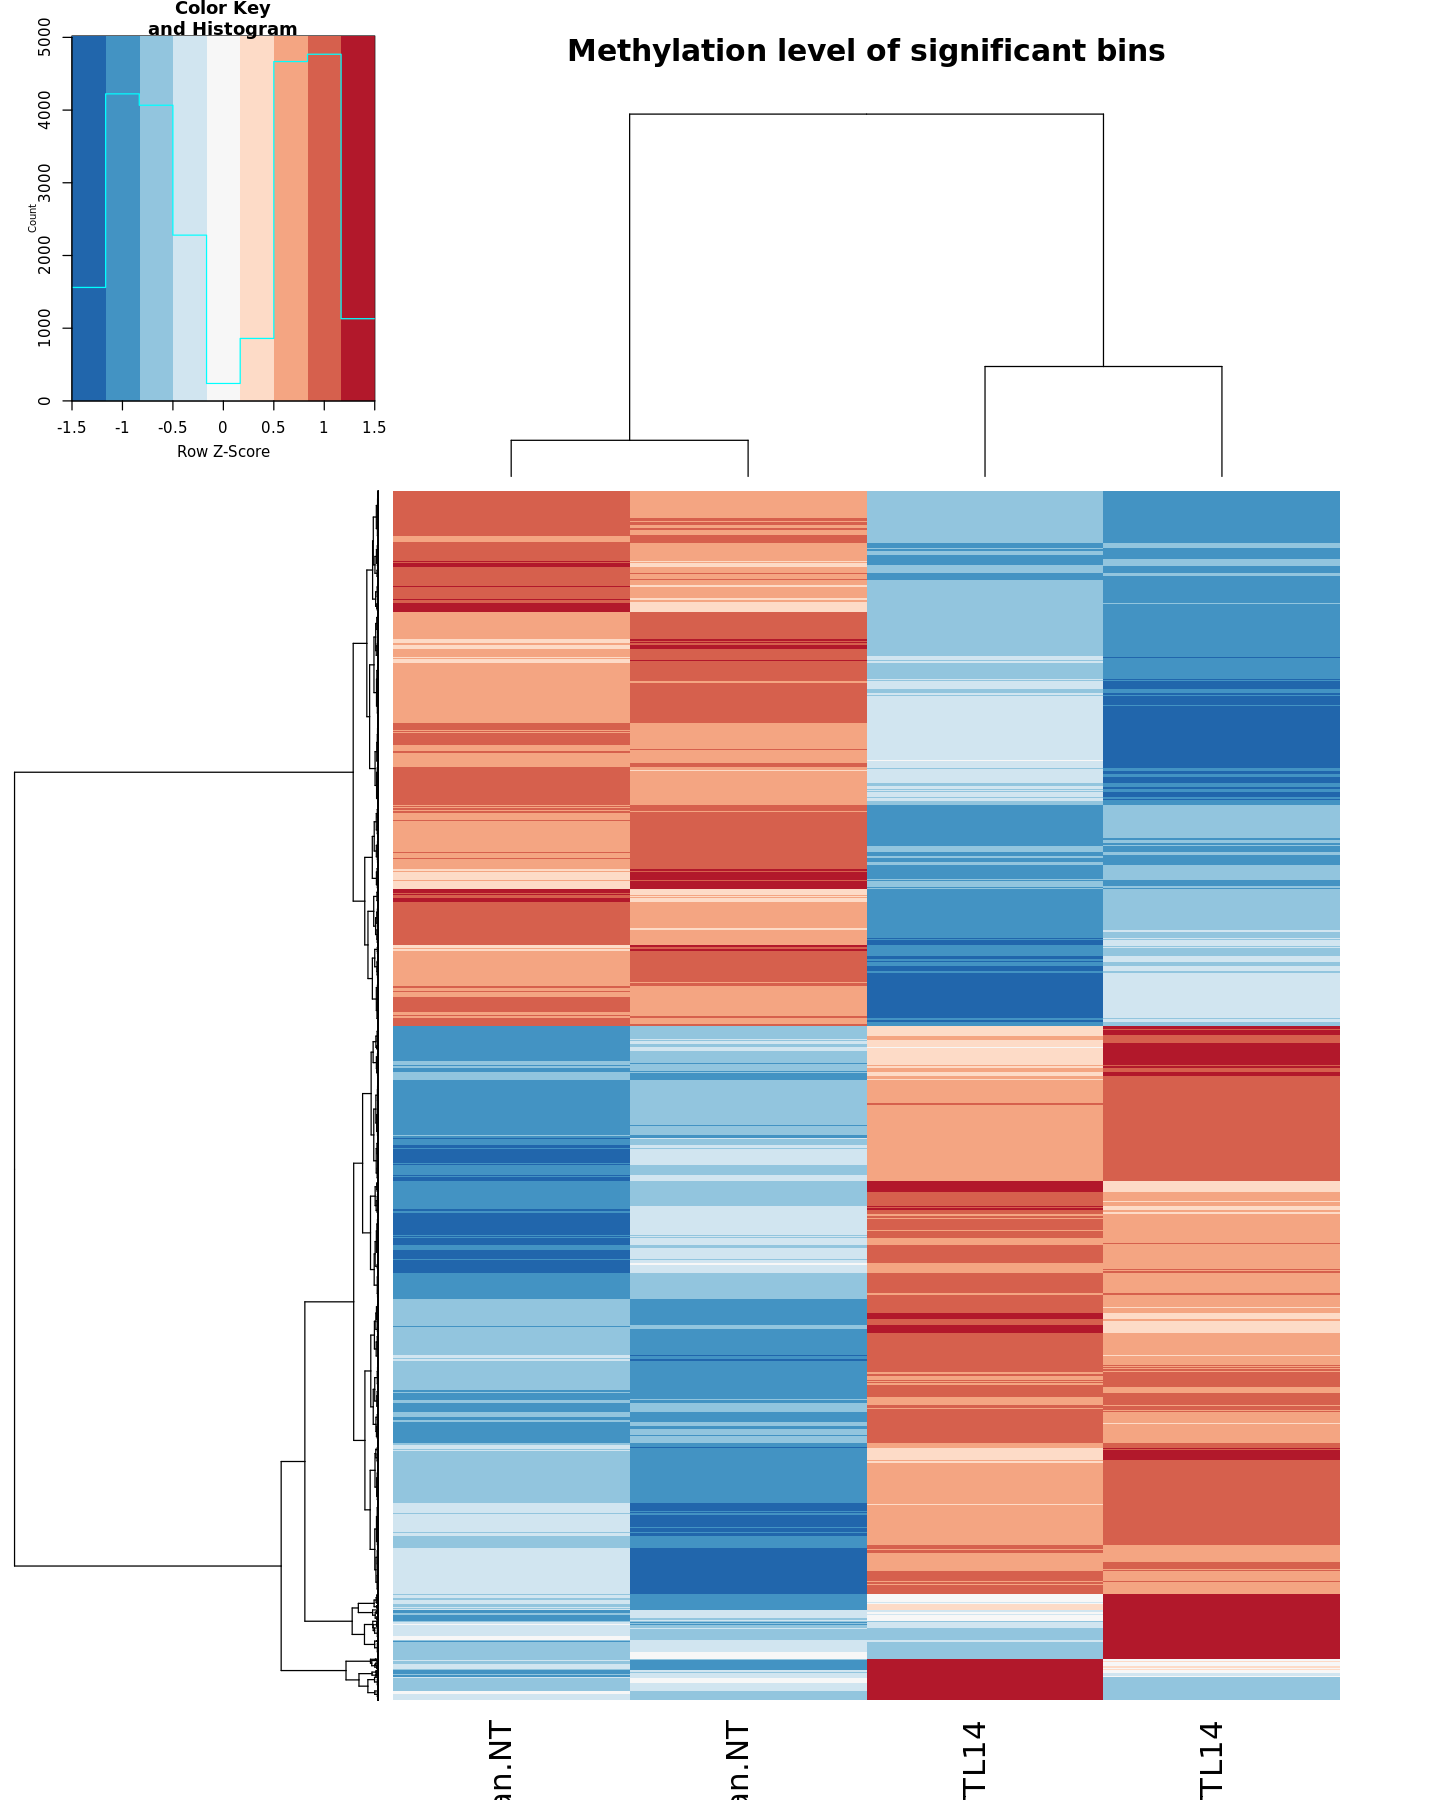

In [57]:
plotHeatMap(radar)

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


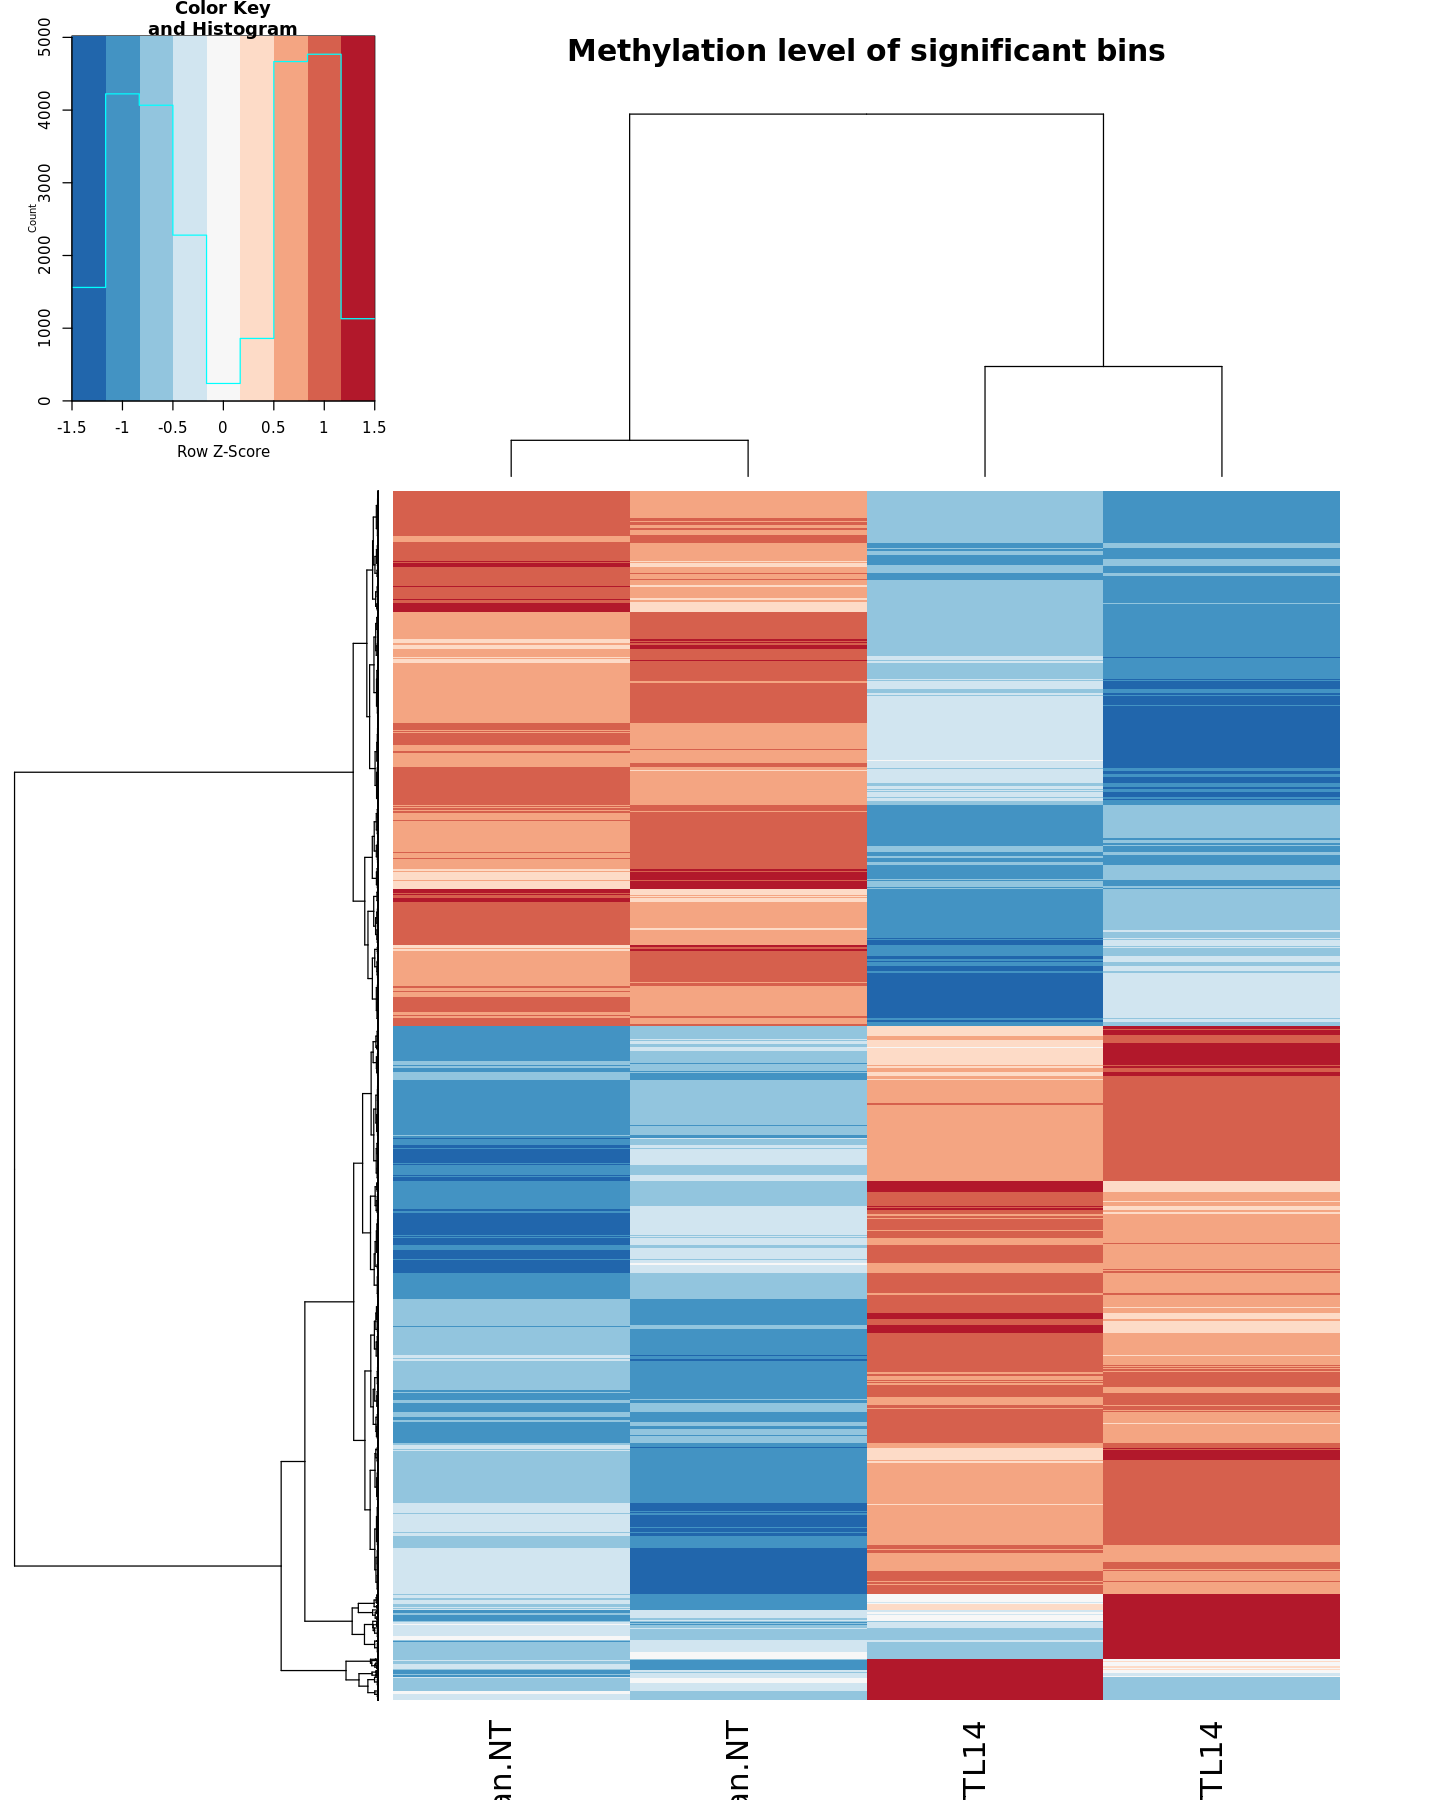

In [58]:
plotHeatMap(radar,covariates = FALSE)

### METTL3

In [59]:
radar = readRDS('radar/human/METTL3/radar.rds')

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


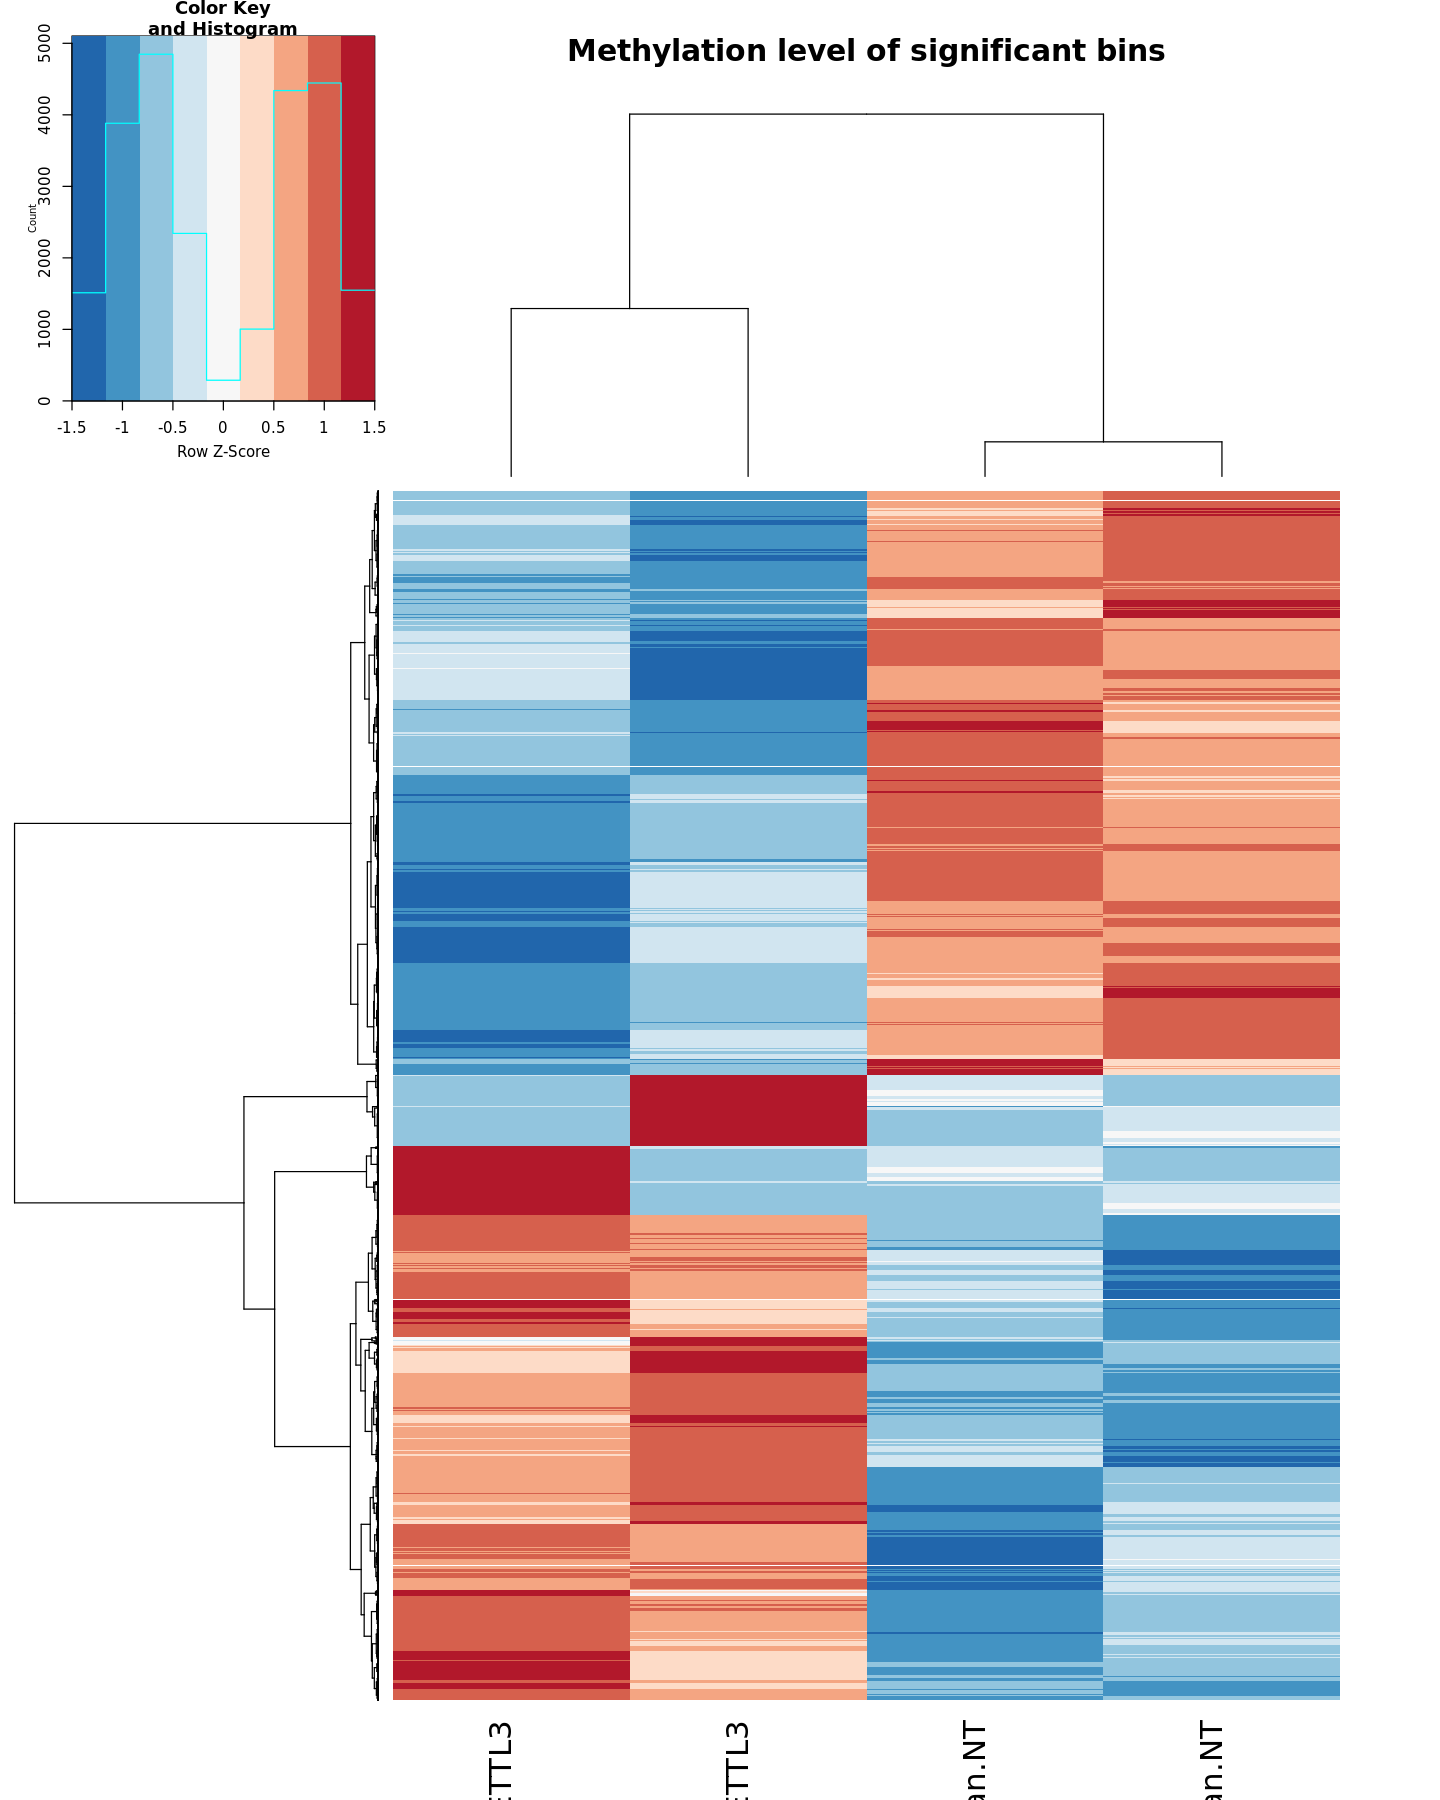

In [60]:
plotHeatMap(radar)

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


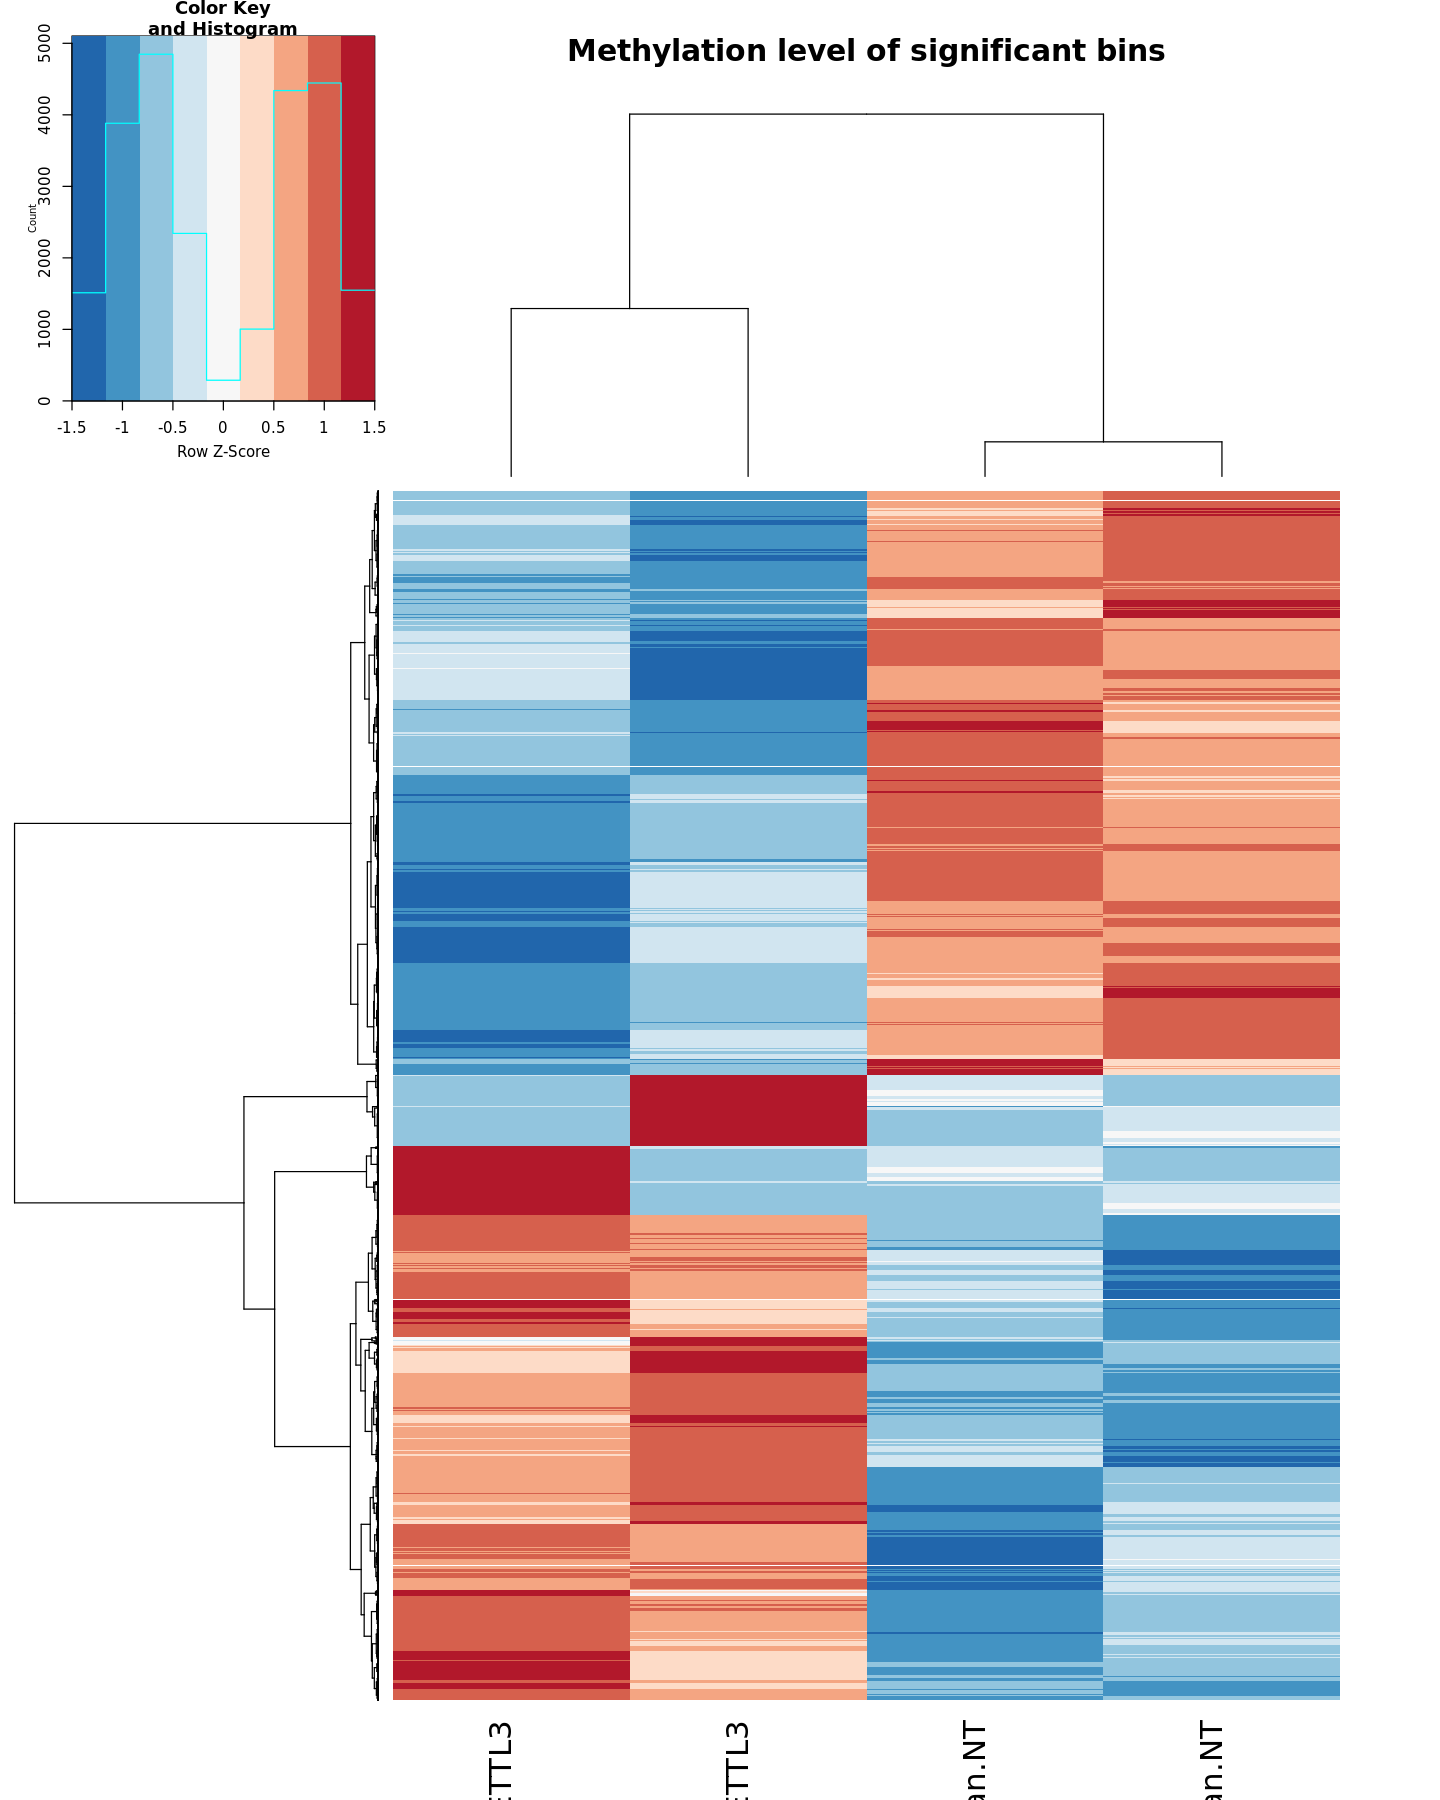

In [61]:
plotHeatMap(radar,covariates = FALSE)

### Virma

In [62]:
radar = readRDS('radar/human/Virma/radar.rds')

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


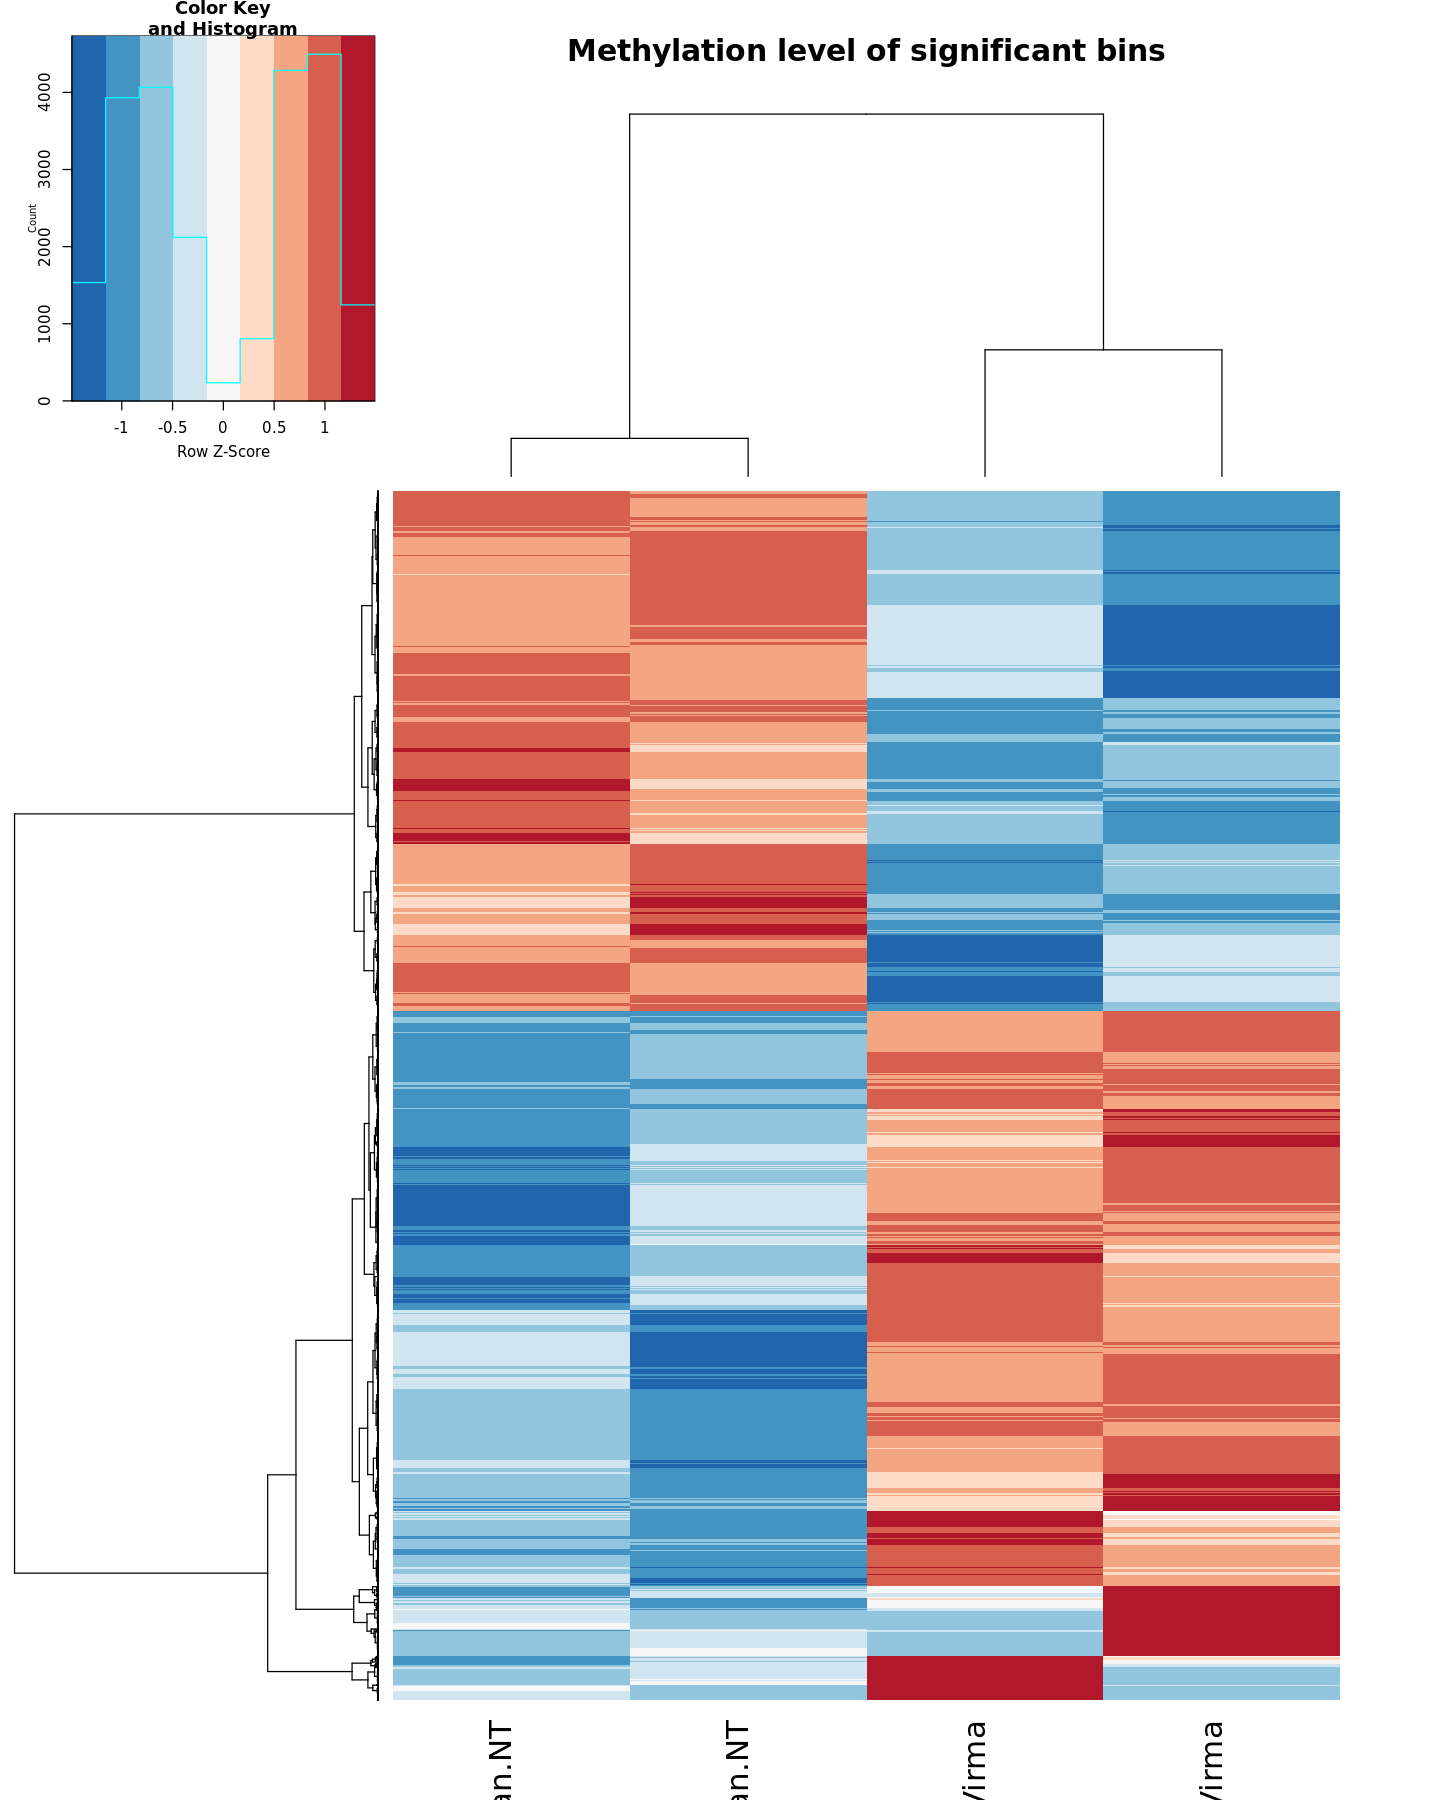

In [63]:
plotHeatMap(radar)

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


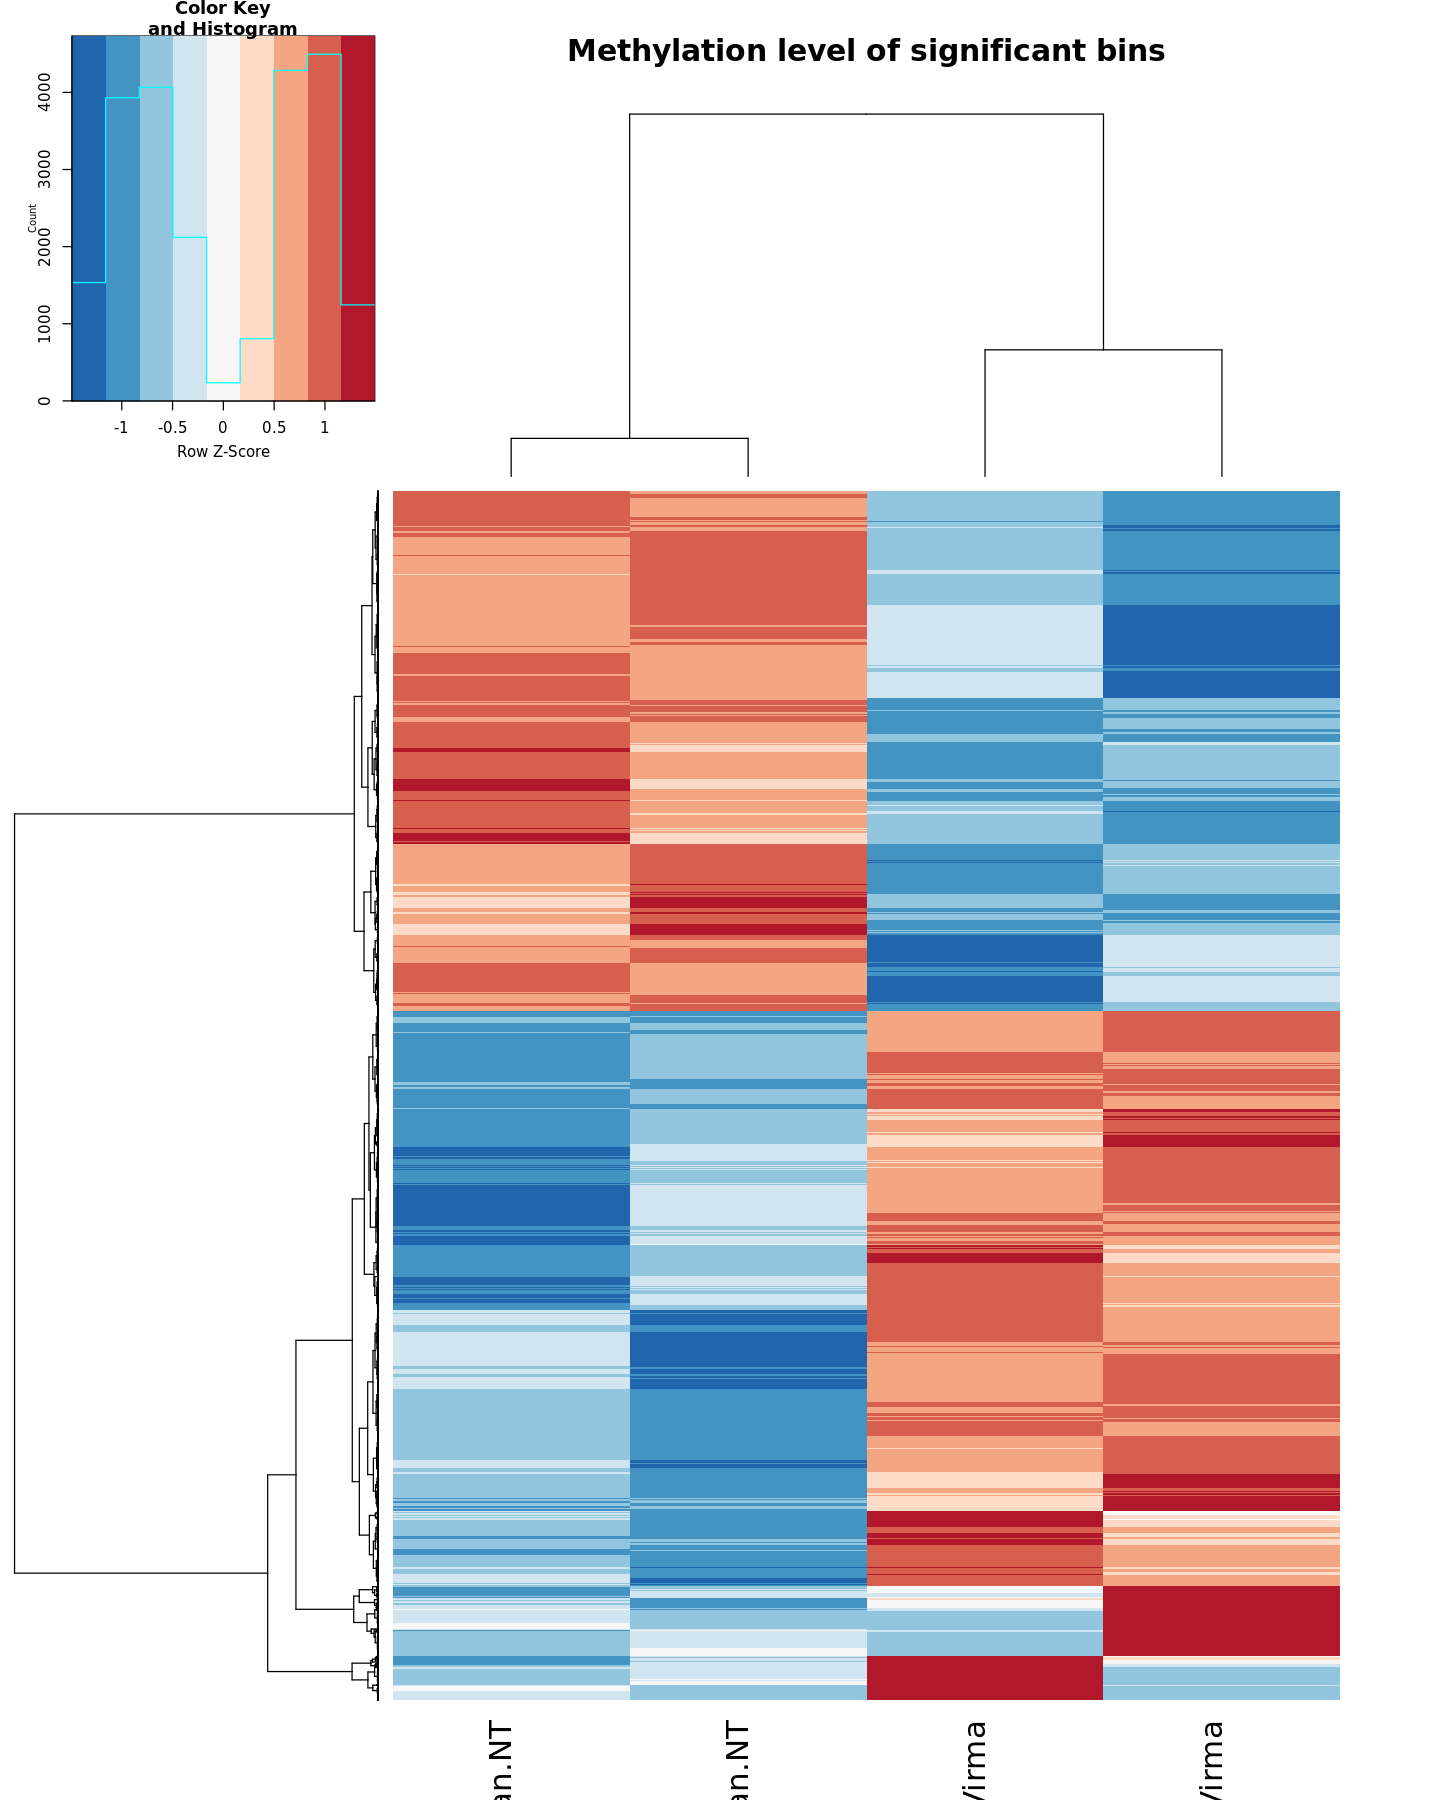

In [64]:
plotHeatMap(radar,covariates = FALSE)

### WTAP

In [65]:
radar = readRDS('radar/human/WTAP/radar.rds')

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


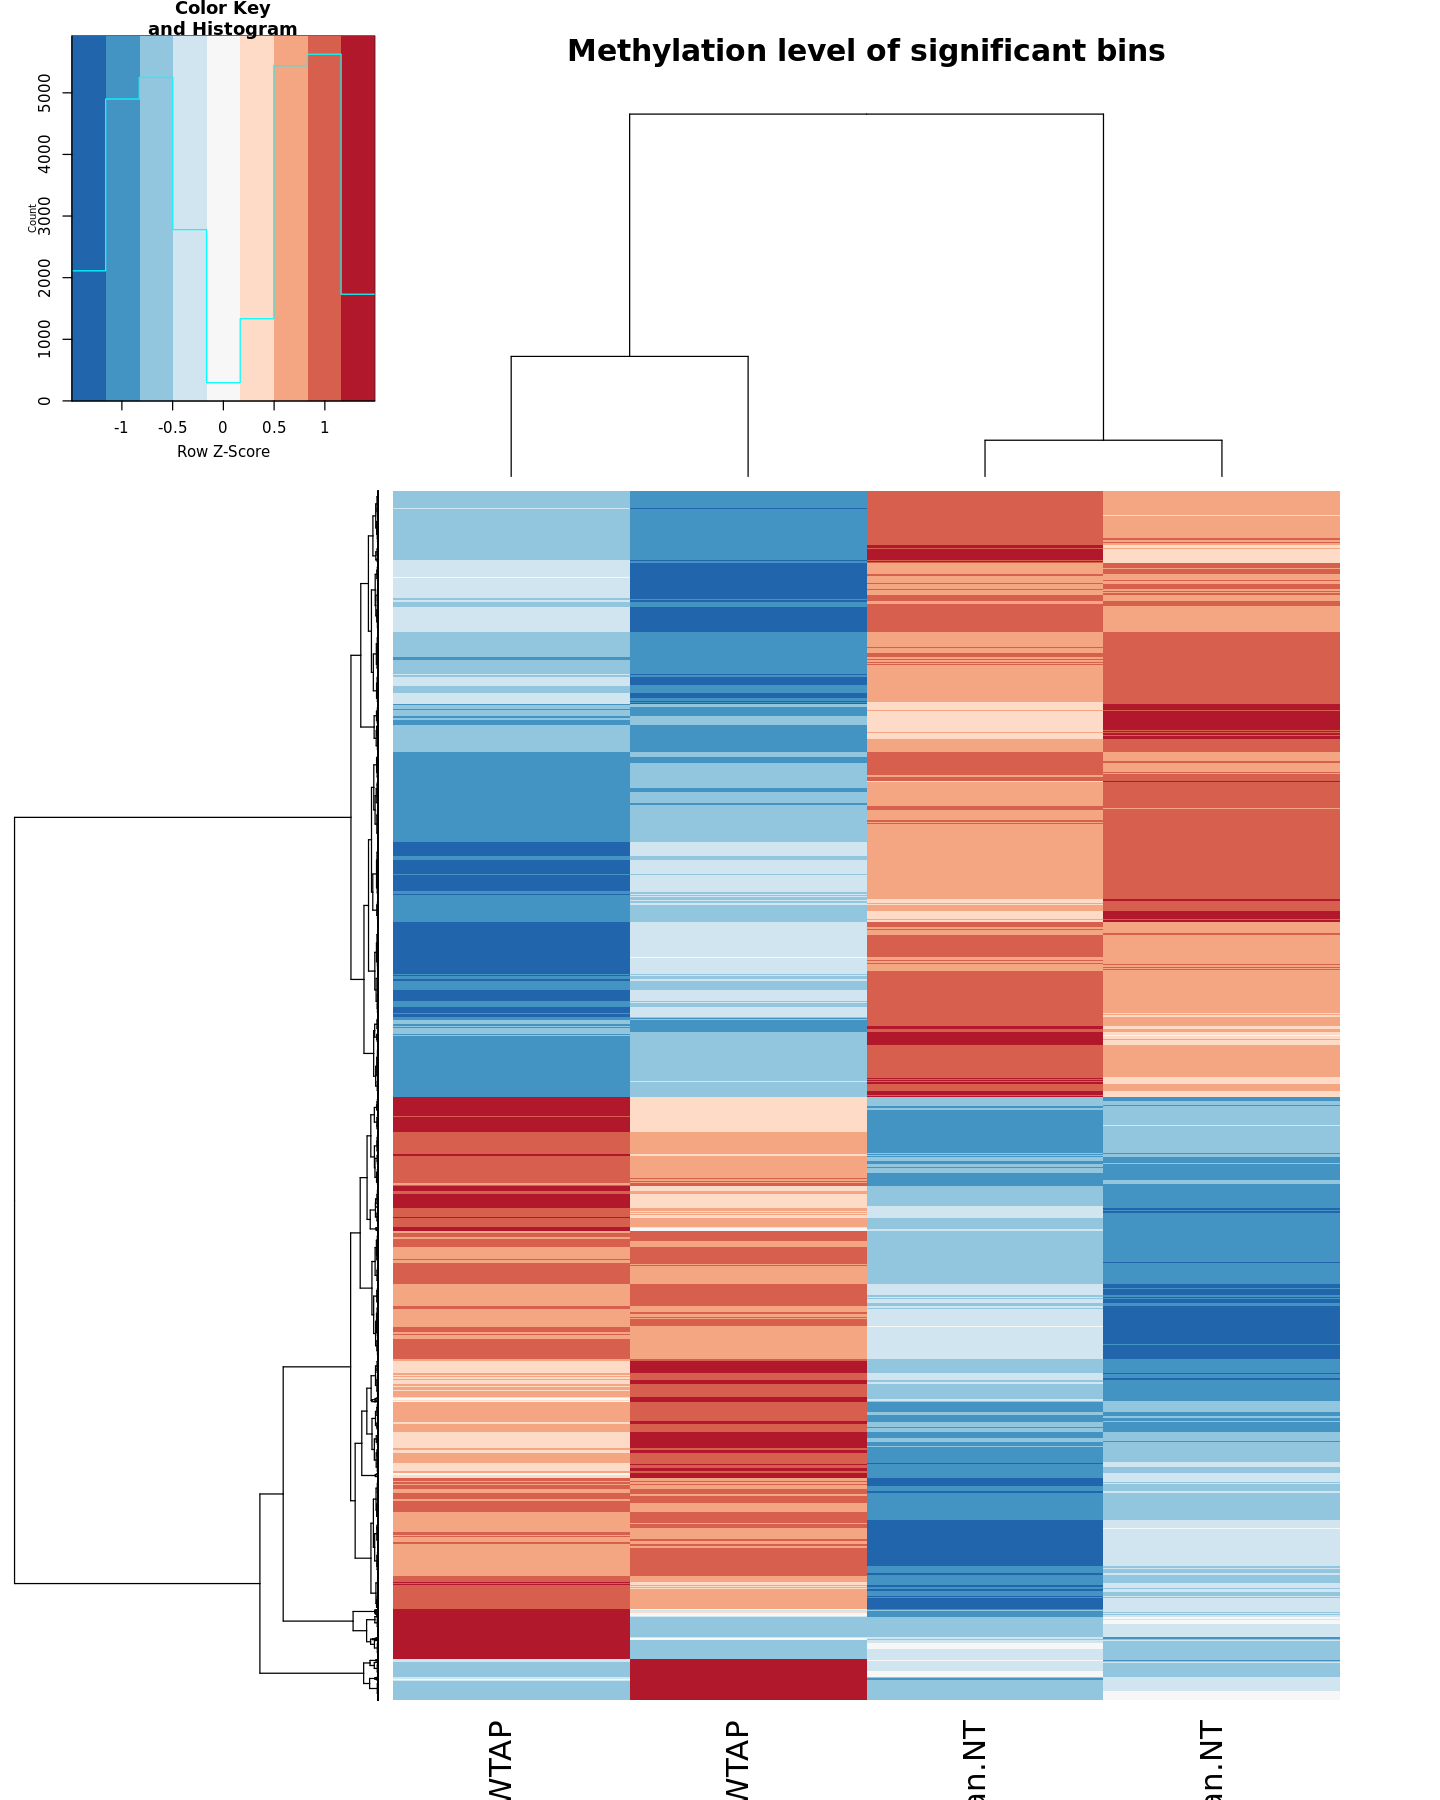

In [66]:
plotHeatMap(radar)

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


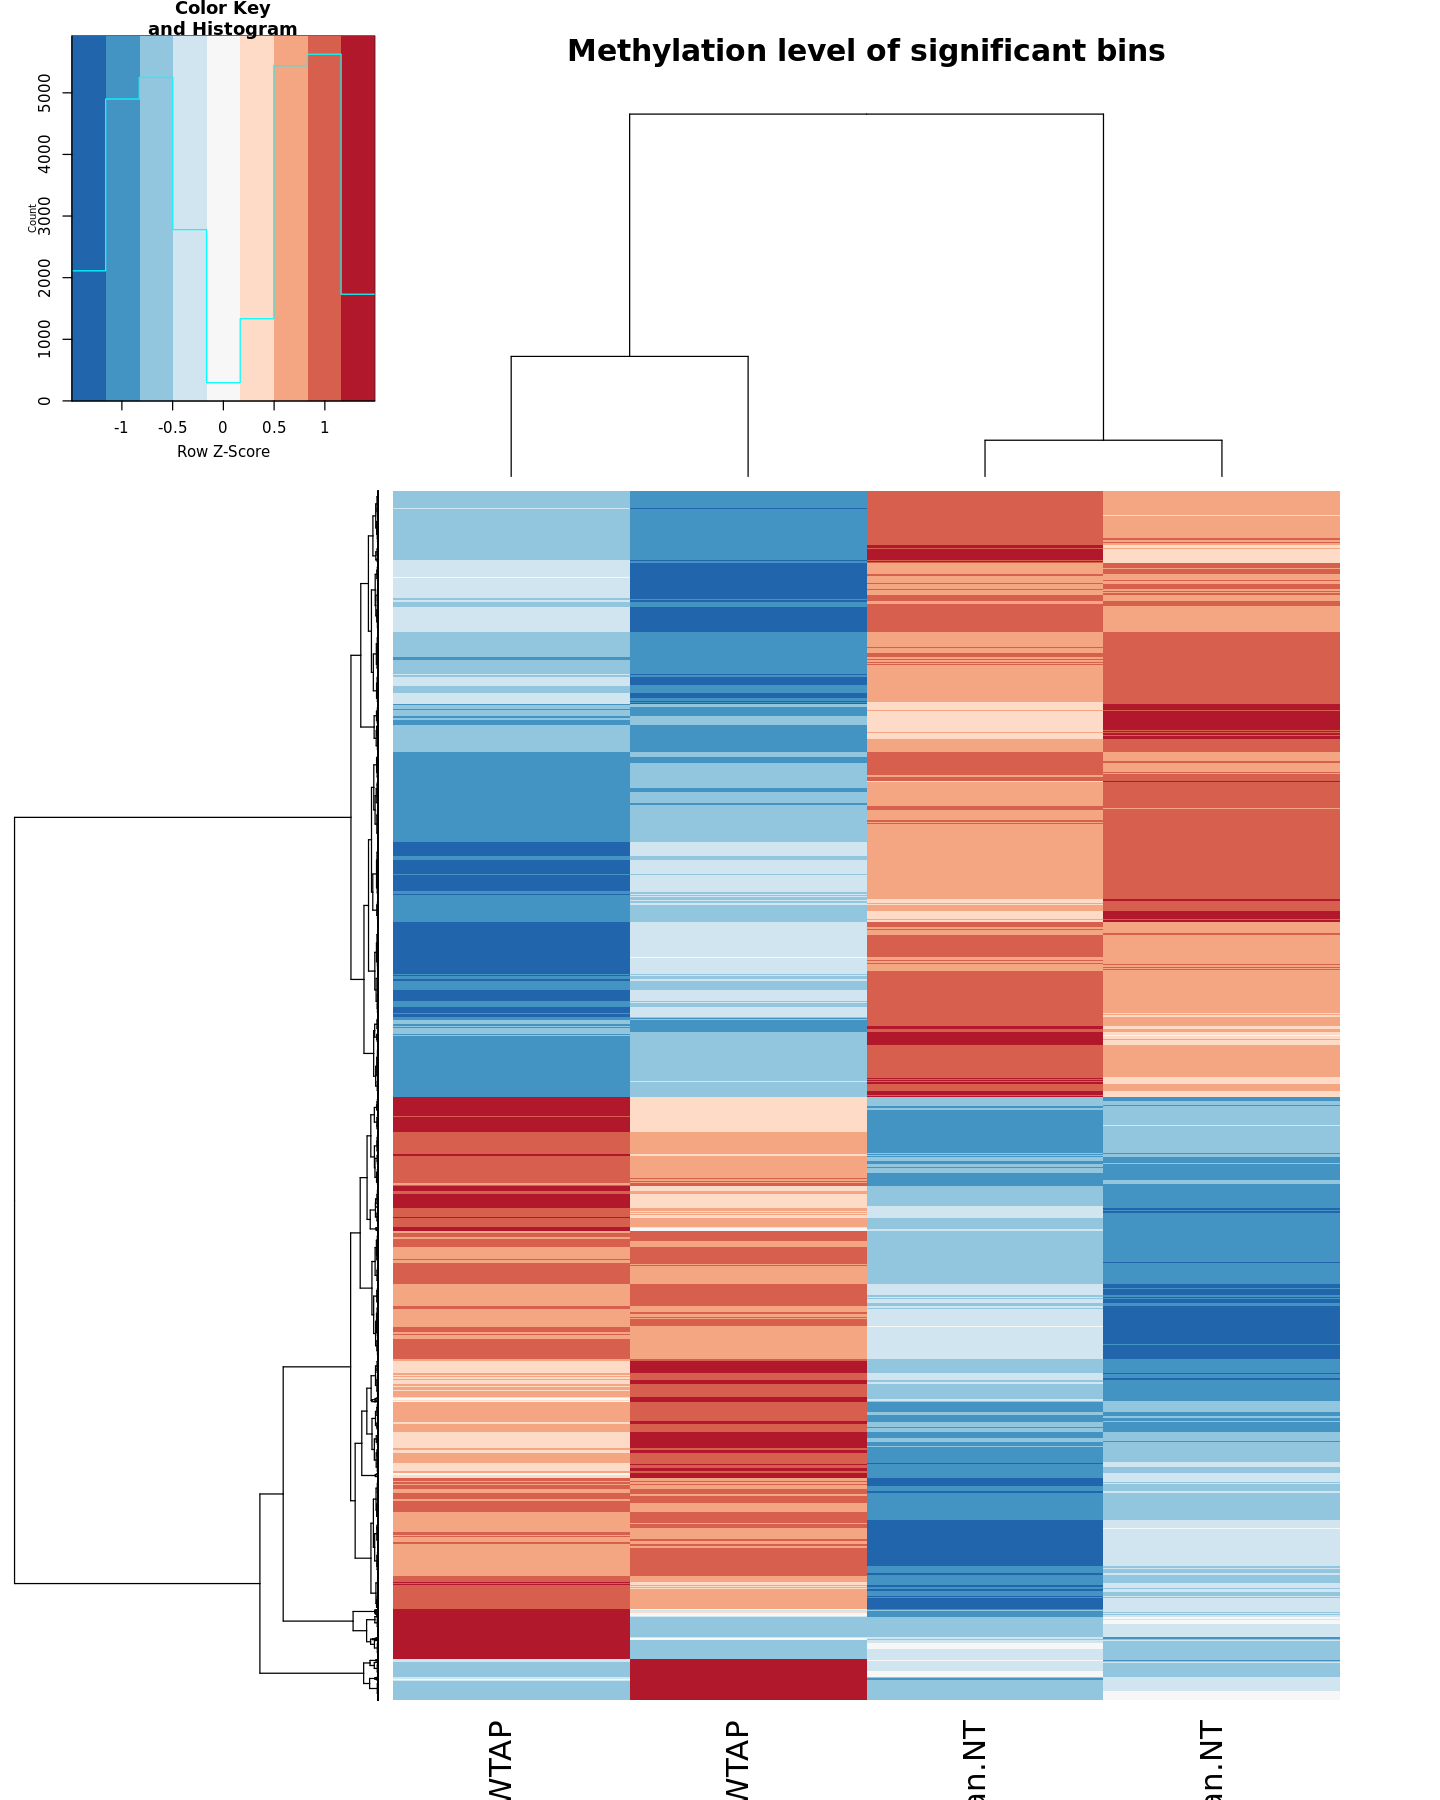

In [67]:
plotHeatMap(radar,covariates = FALSE)

# Control

exomepeak ran with different conda `environment` 

`bash` scripts:

`motifs_of_interest.txt` contains:
- `[AG]GAC`
- `[AGT][AG]AC[ACT]`


In [ ]:
display_png(file = 'exomepeak/human/control/motifs_of_interest_FIRE/RNA/peaks_teiser.txt.dist.rep_OUT/')

In [33]:
library(metagene)

In [78]:
IP_BAM=list.files(path = 'bam', pattern='human.NT.input.bam$')
INPUT_BAM=list.files(path = 'bam', pattern='human.NT.m6A.bam$')
bam_files = paste('bam', c(IP_BAM,INPUT_BAM), sep = '/')

In [79]:
named_bam_files <- bam_files
names(named_bam_files) <- letters[seq_along(bam_files)]
named_bam_files

a                            b 
"bam/s23.human.NT.input.bam" "bam/s24.human.NT.input.bam" 
                           c                            d 
  "bam/s23.human.NT.m6A.bam"   "bam/s24.human.NT.m6A.bam"

In [80]:
regions = 'exomepeak/human/control/peak.c.bed'
regions

[1] "exomepeak/human/control/peak.c.bed"

In [81]:
# Initialization
mg <- metagene$new(regions = regions, bam_files = bam_files)

In [82]:
mg$produce_data_frame()
df <- mg$get_data_frame()
plot_metagene(df)

Warning message in normalizePath(bam_files):
"path[1]="s23.human.NT.m6A": No such file or directory"Warning message in normalizePath(bam_files):
"path[1]="s24.human.NT.m6A": No such file or directory"Warning message in normalizePath(bam_files):
"path[1]="s23.human.NT.m6A": No such file or directory"Warning message in normalizePath(bam_files):
"path[1]="s23.human.NT.m6A": No such file or directory"Warning message in normalizePath(bam_files):
"path[1]="s24.human.NT.m6A": No such file or directory"Warning message in normalizePath(bam_files):
"path[1]="s24.human.NT.m6A": No such file or directory"produce data table : ChIP-Seq


ERROR: Error in intoNbins(gr, bcount): all 'width(gr)' must be >= 'n'


- https://bioconductor.org/packages/release/bioc/vignettes/metagene/inst/doc/metagene.html
- https://plastid.readthedocs.io/en/latest/examples/metagene.html

# run piranha on HIV bam files 

`bash` scripts:

In [75]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/RADAR/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] metagene_2.18.0           BiocParallel_1.20.0      
 [3] R6_2.4.1                  RADAR_0.2.1              
 [5] qvalue_2.18.0             RcppArmadillo_0.9.800.4.0
 [7] Rcpp_1.0.3                RColorBrewer_1.1-2       
 [9] gplots_3.0.1.2            doParallel_1.0.1

In [ ]:
# ###############################  .bed to .fa ######################################### #
# use bioconda ucsc-twobittofa
# conda activate bedtools
# # remove duplicates from bed file
# grep -v '#' peak.bed | awk 'BEGIN{OFS="\t"}{print $1,$2,$3,$4,"1",$6}' > peak.c.bed
# twoBitToFa -noMask -bed=peak.drop_dup.bed /rumi/shams/genomes/hg38/hg38.2bit peak.fa